# Run the Fixed Point Finder algorithm on a GRU that makes a binary decision about its input.

The goal of this tutorial is to learn about fixed point finding by running the algorithm on a simple data generator, a Gated Recurrent Unit (GRU) that is trained to make a binary decision, namely whether the integral of the white noise input is in total positive or negative, outputing either a +1 or a -1.

Running the fixed point finder on this decision-making GRU will yield:
1. the underlying fixed points
2. the first order taylor series approximations around those fixed points.

Doing this will exercise the concepts defined in the [Opening the black box: low-dimensional dynamics in high-dimensional recurrent neural networks](https://www.mitpressjournals.org/doi/full/10.1162/NECO_a_00409). It's pretty important that you have read at least the beginning of the paper, otherwise you won't understand *why* we are doing what we are doing.

Applying this technique was done with some success in the following papers
* [Context-dependent computation by recurrent dynamics in prefrontal cortex](https://www.nature.com/articles/nature12742)
* [A neural network that finds a naturalistic solution for the production of muscle activity](https://www.nature.com/articles/nn.4042)

In this tutorial we do a few things:
1. Train the decision making GRU
2. Find the fixed points of the GRU.
3. Find the jacobians ($\partial{F}/\partial{h}$), where $h$ is the hidden state and $F$ is the GRU and eigenvalues of those jacobians.
4. Show how the linear dynamics explain this example. 

### Why do we care about fixed points? 
1. Because they show where the memory of the system is.
2. (More importantly) One can linearize the dynamics around the fixed points and have reasonable approximations.

$ F(h) = F(h^*) + F'(h^*)(h-h^*) + \frac{1}{2}F''(h^*)(h-h^*)^2 + \cdots$

So if we expand around a fixed point $h^*$, then we can see that the first order approximation is likely to be accurate up to $(h-h^*)^2$.  Thus if $h-h^*$ is small, we likely have a very good approximation of the system.  

Emprically, the volumes around which lineariation is valid needs to be studied for computational dynamics systems, such as recurrent neural networks like a GRU.

Finally, assuming the linear system is a valid approximation, one can study the linearized system via standard analyses, such as eigenvalue / eigenvector decomposition.

#### Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

### Imports

In [1]:
# Numpy, JAX, Matplotlib and h5py should all be correctly installed and on the python path.
from __future__ import print_function, division, absolute_import
import datetime
import h5py
import jax.numpy as np
from jax import jacrev, random, vmap
from jax.experimental import optimizers
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as onp             # original CPU-backed NumPy
import torch
import os
import sys
import time
import logging
import pickle

import torch
import torch.nn as nn
import torchtext

from pdb import set_trace as b

In [2]:
# Import the tutorial code.
from imp import reload

# You must change this to the location of computation-thru-dynamics directory.
HOME_DIR = '/home/ubuntu/' 

sys.path.append(os.path.join(HOME_DIR,'computation-thru-dynamics'))
import fixed_point_finder.decision as decision
import fixed_point_finder.fixed_points as fp_optimize
import fixed_point_finder.rnn as rnn
import fixed_point_finder.utils as utils

In [3]:
text_field = torchtext.data.Field(lower=True, tokenize='spacy', include_lengths=True)


class BinarySentimentModel(nn.Module):
    def __init__(self, text_field, emb_dim, hidden_dim, rnn_cls=nn.GRU):
        super().__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.text_field = text_field
        self.vocab = text_field.vocab
        self.emb = nn.Embedding(len(self.vocab), emb_dim, padding_idx=self.vocab.stoi[text_field.pad_token])
        self.rnn = rnn_cls(input_size=emb_dim, hidden_size=hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        if isinstance(x, torch.nn.utils.rnn.PackedSequence):
            embs = torch.nn.utils.rnn.PackedSequence(self.emb(x.data), x.batch_sizes)
        else:
            embs = self.emb(x)
            
        # RNN layer returns sequence of hidden states and the final hidden state for each sequence in batch                                                                                                                                                   
        h, h_final = self.rnn(embs)
        logits = self.fc(h_final.squeeze(0))
        return logits.view(-1), h

def jax_rnn_from_params(params):
    def rnn_output(x, h_0):
        return rnn.batched_rnn_run_w_h0_pytorch(params, x, h_0)
    return rnn_output
    
class BinarySentimentModelJAXd(nn.Module):
    def __init__(self, text_field, emb_dim, hidden_dim, rnn_jax):
        super().__init__()
        self.emb_dim = emb_dim
        self.hidden_dim = hidden_dim
        self.text_field = text_field
        self.vocab = text_field.vocab
        self.emb = nn.Embedding(len(self.vocab), emb_dim, padding_idx=self.vocab.stoi[text_field.pad_token])
        # self.rnn = rnn_cls(input_size=emb_dim, hidden_size=hidden_dim)
        self.rnn = rnn_jax
        self.fc = nn.Linear(hidden_dim, 1)
        
        
    def forward(self, x):
        if isinstance(x, torch.nn.utils.rnn.PackedSequence):
            embs = torch.nn.utils.rnn.PackedSequence(self.emb(x.data), x.batch_sizes)
        else:
            embs = self.emb(x)
        
        h_0 = np.zeros((x.shape[1], self.hidden_dim))  # (n_batch x hidden_dim)
        # RNN layer returns sequence of hidden states and the final hidden state for each sequence in batch                                                                                                                                                   
        h, h_final = self.rnn(torch.transpose(embs.data, 0, 1).cpu().numpy(), h_0)
        
        logits = self.fc(torch.tensor(onp.array(h_final)).cuda())
        
        return logits.view(-1), h
        # logits.view(-1):  (batch_size,)
        # h:  (batch_size, seq_len, hidden_dim)
    
    
class Examples(object):
    def __init__(self, batches):
        self.batches = batches

    def __len__(self):
        return len(self.batches)

    def __iter__(self):
        for batch in self.batches:
            x = torch.nn.utils.rnn.pack_padded_sequence(batch.text[0], lengths=batch.text[1].cpu())
            y = (batch.label - 1).float()  # labels are [<unk>, neg, pos]                                                                                                                                                                                     
            yield x, y

/home/ubuntu/anaconda3/envs/neural-universality/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [4]:
logging.basicConfig(format='%(asctime)s %(levelname)-8s %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
torch

<module 'torch' from '/home/ubuntu/anaconda3/envs/neural-universality/lib/python3.8/site-packages/torch/__init__.py'>

## Load Data

In [6]:
def load_imdb_data(
        data_root, vocab_min_freq, batch_size,
        device='cuda:0', preprocessed_path=None):
    logger.info('Loading and preprocessing IMDB data')
    try:
        tokenize = 'spacy' if (preprocessed_path is None) else None
        text_field = torchtext.data.Field(lower=True, tokenize=tokenize, include_lengths=True)
    except:
        raise RuntimeError('Ensure that spacy is installed with `conda install spacy` and that the spacy English '
                           'models are downloaded with `spacy download en`')
    label_field = torchtext.data.Field(sequential=False)
    train_data, test_data = torchtext.datasets.IMDB.splits(text_field, label_field, root=data_root)
    if preprocessed_path is not None:
        logger.info('Loading preprocessed data from {}'.format(preprocessed_path))
        train_examples, test_examples = torch.load(preprocessed_path)
        train_data.examples = train_examples
        test_data.examples = test_examples
    text_field.build_vocab(train_data, min_freq=vocab_min_freq)
    label_field.build_vocab(train_data)
    train_iter, test_iter = torchtext.data.BucketIterator.splits(
        (train_data, test_data), batch_size=batch_size, device=device, shuffle=True,
        repeat=False, sort_within_batch=True)
    train_batches, test_batches = Examples(train_iter), Examples(test_iter)
    logger.info('# train examples = %d' % len(train_data))
    logger.info('vocabulary size = %d' % len(text_field.vocab))
    return train_batches, test_batches, text_field, label_field

In [7]:
data_root = '/tmp'
vocab_min_freq = 5
batch_size = 32
device = 'cuda:0'
preprocessed_path = None


try:
    train_batches, test_batches, text_field, label_field = pickle.load(open('data.pkl', 'rb'))
except:
    train_batches, test_batches, text_field, label_field = load_imdb_data(
            data_root, vocab_min_freq, batch_size, device=device, preprocessed_path=preprocessed_path)
    pickle.dump((list(train_batches), list(test_batches), text_field, label_field), open('data.pkl', 'wb'))

In [8]:
batch = list(train_batches.__iter__())

In [9]:
len(batch)

782

In [10]:
batch[0]

(PackedSequence(data=tensor([  13, 1063,   31,  ...,    4,    4,    4], device='cuda:0'), batch_sizes=tensor([32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
         32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
         32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
         32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
         32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
         32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
         32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
         32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
         32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 29, 10]), sorted_indices=None, unsorted_indices=None),
 tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
         0., 0., 0., 1., 0., 1., 0., 1., 0., 0

In [11]:
batch[0][0].data.shape

torch.Size([5127])

In [12]:
[text_field.vocab.itos[x] for x in batch[0][0].data]

['this',
 'caught',
 'not',
 'it',
 'why',
 'the',
 'the',
 'this',
 'no',
 'now',
 'an',
 'this',
 '<unk>',
 'i',
 'this',
 'this',
 'the',
 'i',
 'wow',
 'this',
 'well',
 'as',
 'terrible',
 'gena',
 "'",
 'i',
 'i',
 'jane',
 'this',
 'the',
 'i',
 'i',
 'movie',
 'the',
 'one',
 'has',
 'did',
 'beginning',
 'subject',
 'is',
 'wonder',
 ',',
 'acted',
 'is',
 'pope',
 'liked',
 'is',
 'was',
 'only',
 "'m",
 ',',
 'series',
 ',',
 'a',
 'film',
 'rowlands',
 'the',
 'saw',
 'was',
 'russell',
 'is',
 'minute',
 'thought',
 'liked',
 'is',
 'tail',
 'of',
 'very',
 'i',
 'of',
 'notwithstanding',
 'not',
 'pamela',
 'i',
 '/',
 'a',
 'plays',
 'top',
 'a',
 'a',
 'film',
 'not',
 'this',
 'had',
 'this',
 'long',
 'made',
 'plays',
 'curse',
 'this',
 'raised',
 'proved',
 'the',
 'the',
 'this',
 'this',
 'nothing',
 'end',
 'your',
 'bad',
 'waste',
 'this',
 ',',
 'michael',
 'springsteen',
 "'m",
 'manipulated',
 'great',
 'jj',
 'gun',
 'great',
 'typical',
 'i',
 'a',
 'movi

## Load PyTorch Sentiment Model

In [13]:
rnn_cell_jax = lambda h, x : rnn.gru_pytorch(pytorch_rnn_params_numpy, h, x)

In [14]:
## Decision Task and Parameters

# GRU and task hyperparameters
u = 256         # Number of inputs to the GRU
n = 128       # Number of units in the GRU
o = 1         # Number of outputs in the GRU

In [15]:
help(text_field)

Help on Field in module torchtext.data.field object:

class Field(RawField)
 |  Field(sequential=True, use_vocab=True, init_token=None, eos_token=None, fix_length=None, dtype=torch.int64, preprocessing=None, postprocessing=None, lower=False, tokenize=None, tokenizer_language='en', include_lengths=False, batch_first=False, pad_token='<pad>', unk_token='<unk>', pad_first=False, truncate_first=False, stop_words=None, is_target=False)
 |  
 |  Defines a datatype together with instructions for converting to Tensor.
 |  
 |  Field class models common text processing datatypes that can be represented
 |  by tensors.  It holds a Vocab object that defines the set of possible values
 |  for elements of the field and their corresponding numerical representations.
 |  The Field object also holds other parameters relating to how a datatype
 |  should be numericalized, such as a tokenization method and the kind of
 |  Tensor that should be produced.
 |  
 |  If a Field is shared between two columns 

In [16]:
text_field.vocab

In [17]:
sentiment_model = BinarySentimentModel(text_field, u, n)
sentiment_model.to(device)

BinarySentimentModel(
  (emb): Embedding(31312, 256, padding_idx=1)
  (rnn): GRU(256, 128)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [18]:
pytorch_params = torch.load('/home/ubuntu/sentiment_models/sentiment-gru128-s1/checkpoints/model.pt')
sentiment_model.load_state_dict(pytorch_params)

<All keys matched successfully>

## Test PyTorch Sentiment Model

In [19]:
model_outputs = sentiment_model(batch[0][0].cuda())[0] > 0

In [20]:
desired_outputs = batch[0][1]

In [21]:
accuracy = sum(model_outputs == desired_outputs) / len(desired_outputs)
accuracy

tensor(1., device='cuda:0')

## Convert PyTorch GRU to JAX

In [22]:
pytorch_params = torch.load('/home/ubuntu/sentiment_models/sentiment-gru128-s1/checkpoints/model.pt')

In [23]:
pytorch_rnn_params = {
    'weight_ih_l0': pytorch_params['rnn.weight_ih_l0'],
    'weight_hh_l0': pytorch_params['rnn.weight_hh_l0'],
    'bias_ih_l0': pytorch_params['rnn.bias_ih_l0'],
    'bias_hh_l0': pytorch_params['rnn.bias_hh_l0'],
}

In [24]:
pytorch_rnn_params_numpy = {
    'weight_ih_l0': pytorch_params['rnn.weight_ih_l0'].cpu().numpy(),
    'weight_hh_l0': pytorch_params['rnn.weight_hh_l0'].cpu().numpy(),
    'bias_ih_l0': pytorch_params['rnn.bias_ih_l0'].cpu().numpy(),
    'bias_hh_l0': pytorch_params['rnn.bias_hh_l0'].cpu().numpy(),
}

In [25]:
### Convert between PyTorch and JAX format

(pytorch_rnn_params['weight_ih_l0'].shape,  # (W_ir|W_iz|W_in), (3*hidden_size, input_size)
pytorch_rnn_params['weight_hh_l0'].shape,  # (W_hr|W_hz|W_hn), (3*hidden_size, hidden_size)
pytorch_rnn_params['bias_ih_l0'].shape, # (b_ir|b_iz|b_in), (3*hidden_size)
pytorch_rnn_params['bias_hh_l0'].shape,) # (b_hr|b_hz|b_hn), (3*hidden_size)

(torch.Size([384, 256]),
 torch.Size([384, 128]),
 torch.Size([384]),
 torch.Size([384]))

In [26]:
W_ir, W_iz, W_in = np.split(pytorch_rnn_params['weight_ih_l0'].cpu().numpy(), 3)
W_ir.shape

2021-07-07 19:53:20,880 WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(128, 256)

In [27]:
W_hr, W_hz, W_hn = np.split(pytorch_rnn_params['weight_hh_l0'].cpu().numpy(), 3)
W_hr.shape

(128, 128)

In [28]:
b_ir, b_iz, b_in = np.split(pytorch_rnn_params['bias_ih_l0'].cpu().numpy(), 3)
b_ir.shape

(128,)

In [29]:
b_hr, b_hz, b_hn = np.split(pytorch_rnn_params['bias_hh_l0'].cpu().numpy(), 3)
b_hr.shape

(128,)

In [30]:
b_in.shape, b_hn.shape

((128,), (128,))

In [31]:
rnn_sequence_jax = jax_rnn_from_params(pytorch_rnn_params_numpy)

In [32]:
# pytorch_rnn = torch.nn.GRU(input_size=256, hidden_size=128)
# pytorch_rnn.load_state_dict(pytorch_rnn_params)

In [33]:
# for param_name in pytorch_params.keys():
#     print(param_name + ': ', pytorch_params[param_name].shape)

In [34]:
################################

# have to do some surgery on these parameters...
# rnn_fun = lambda h : rnn.gru(pytorch_params_renamed, h, x_star)  # change this definition?
# rnn_fun = lambda h : pytorch_rnn(torch.tensor(x_star), torch.tensor(h))
rnn_fun = lambda h : rnn.gru_pytorch(pytorch_rnn_params_numpy, h, x_star)  # change this definition?
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))


################################

In [35]:
sentiment_model_jax = BinarySentimentModelJAXd(text_field, u, n, rnn_sequence_jax)
sentiment_model_jax.to(device)

BinarySentimentModelJAXd(
  (emb): Embedding(31312, 256, padding_idx=1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [36]:
pytorch_params = torch.load('/home/ubuntu/sentiment_models/sentiment-gru128-s1/checkpoints/model.pt')
del pytorch_params['rnn.weight_ih_l0']
del pytorch_params['rnn.weight_hh_l0']
del pytorch_params['rnn.bias_ih_l0']
del pytorch_params['rnn.bias_hh_l0']
sentiment_model_jax.load_state_dict(pytorch_params)

<All keys matched successfully>

## Test JAX Sentiment Model

In [43]:
logits, hiddens = sentiment_model_jax(
    torch.nn.utils.rnn.pad_packed_sequence(
        batch[0][0].cuda()
    )[0] # batched
)

In [44]:
model_outputs = (logits > 0)

In [45]:
desired_outputs = batch[0][1]

In [46]:
accuracy = sum(model_outputs == desired_outputs) / len(desired_outputs)
accuracy

tensor(1., device='cuda:0')

##### TODO: Print the batch itself (convert embeddings to language tokens)

### Looks like JAX-PyTorch hybrid model is working!!!

## Generate Typical Hidden States

In [42]:
# Visualize how good this trained integrator is
'''def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = \
        decision.build_inputs_and_targets_jit(input_params, keys)
    h0s_b = None # Use trained h0
    masks_b = None # Not used
    return inputs_b, targets_b, masks_b, h0s_b

rnn_run = lambda inputs: rnn.batched_rnn_run_pytorch(params, inputs)

give_trained_h0 = lambda batch_size : np.array([params['h0']] * batch_size)

nexamples = 400
rnn_internals = rnn.run_trials(rnn_run, inputs_targets_no_h0s, 1, nexamples)

decision.plot_batch(input_params, rnn_internals['inputs'], 
                    rnn_internals['targets'], rnn_internals['outputs'], 
                    onp.abs(rnn_internals['targets'] - rnn_internals['outputs']), ntoplot=10)'''


"def inputs_targets_no_h0s(keys):\n    inputs_b, targets_b, masks_b =         decision.build_inputs_and_targets_jit(input_params, keys)\n    h0s_b = None # Use trained h0\n    masks_b = None # Not used\n    return inputs_b, targets_b, masks_b, h0s_b\n\nrnn_run = lambda inputs: rnn.batched_rnn_run_pytorch(params, inputs)\n\ngive_trained_h0 = lambda batch_size : np.array([params['h0']] * batch_size)\n\nnexamples = 400\nrnn_internals = rnn.run_trials(rnn_run, inputs_targets_no_h0s, 1, nexamples)\n\ndecision.plot_batch(input_params, rnn_internals['inputs'], \n                    rnn_internals['targets'], rnn_internals['outputs'], \n                    onp.abs(rnn_internals['targets'] - rnn_internals['outputs']), ntoplot=10)"

In [47]:
hiddens.shape

(32, 161, 128)

# Fixed point analysis

Now that we've loaded this GRU to determine whether sentiment is positive or negative, we can analyze the system via fixed point analysis.

In [53]:
# These are some preliminaries. 
x_star = np.zeros(u)  # We always linearize the input around zero in this example.

# Make a one parameter function of thie hidden state, useful for jacobians.
rnn_fun = lambda h : rnn.gru_pytorch(pytorch_rnn_params_numpy, h, x_star) #  rnn.gru(params, h, x_star)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))

In [54]:
u

256

### Create some functions that define the fixed point loss
which is just the squared error of a point $(h - F(h))^2$ for a discrete time system such as a GRU.

In [55]:
fp_loss_fun = fp_optimize.get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = fp_optimize.get_total_fp_loss_fun(rnn_fun)

In [56]:
rnn_internals = []

We have to start the fixed point finder with some points, and it's always 
best to start with examples of where the state normally operates.

In [62]:
fp_candidates = hiddens  # was batch x time x dim
fp_candidates = np.reshape(fp_candidates, (-1, n)) # now batch * time x dim

In [63]:
fp_candidates.shape

(5152, 128)

In [64]:
32 * 161

5152

In [65]:
'''num_batches = 1
num_hidden_units = n

fp_candidates = np.zeros((num_batches, num_hidden_units))
fp_candidates.shape'''

'num_batches = 1\nnum_hidden_units = n\n\nfp_candidates = np.zeros((num_batches, num_hidden_units))\nfp_candidates.shape'

In [66]:
# Fixed point optimization hyperparameters
fp_num_batches = 10000         # Total number of batches to train on.
fp_batch_size = 128          # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.025   # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.

When optimizing for fixed points, we set a few different stopping thresholds and run the fixed point finder a few times.  This is because there are rarely true numerical fixed points, though they do happen.  Instead one has slow points of varying slowness.  My experience is that if the dynamics of the slow point is very slow relative to the normal speed of the dynamics during the task / computation / behavior, then the slow point is effectively acting as a fixed point.  Moving forward, in the code, and in the comments, I always refer to slow points as fixed points, with the understanding that we are being informal. By having a few tolerances of varying slowness, we ensure we capture a large variety of the fixed points and likely get a better understanding of what the system is doing.

In [ ]:
#try:
reload(fp_optimize)

fp_tols = [0.0001, 0.00001, 0.000001] # Used for both fp_tol and opt_stop_tol

all_fps = {}
for tol in fp_tols:
    fp_hps = {'num_batches' : fp_num_batches, 
              'step_size' : fp_step_size, 
              'decay_factor' : fp_decay_factor, 
              'decay_steps' : fp_decay_steps, 
              'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2, 'adam_eps' : fp_adam_eps,
              'noise_var' : fp_noise_var, 
              'fp_opt_stop_tol' : tol, 
              'fp_tol' : tol, 
              'unique_tol' : fp_unique_tol, 
              'outlier_tol' : fp_outlier_tol, 
              'opt_print_every' : fp_opt_print_every}

    fps, fp_losses, fp_idxs, fp_opt_details = \
        fp_optimize.find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)  # change how rnn_fun is defined?
    if len(fp_idxs) > 0:
        F_of_fps = batch_rnn_fun(fps)
    else:
        F_of_fps = onp.zeros([0,n])

    b()
    candidates = fp_candidates[fp_idxs]
    all_fps[tol] = {'fps' : fps, 'candidates' : candidates,
                    'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                    'opt_details' : fp_opt_details, 'hps' : fp_hps}

    all_fps[tol]
#except:
#    b()

Optimizing to find fixed points.
    Batches 1-200 in 0.42 sec, Step size: 0.19604, Training loss 0.00132
    Batches 201-400 in 0.43 sec, Step size: 0.19216, Training loss 0.00056
    Batches 401-600 in 0.42 sec, Step size: 0.18835, Training loss 0.00034
    Batches 601-800 in 0.42 sec, Step size: 0.18462, Training loss 0.00024
    Batches 801-1000 in 0.43 sec, Step size: 0.18097, Training loss 0.00018
    Batches 1001-1200 in 0.42 sec, Step size: 0.17738, Training loss 0.00015
    Batches 1201-1400 in 0.42 sec, Step size: 0.17387, Training loss 0.00013
    Batches 1401-1600 in 0.44 sec, Step size: 0.17043, Training loss 0.00011
    Batches 1601-1800 in 0.43 sec, Step size: 0.16705, Training loss 0.00010
Stopping as mean training loss 0.00010 is below tolerance 0.00010.
Excluding fixed points with squared speed above tolerance 0.00010.
    Kept 2971/5152 fixed points with tolerance under 0.000100.
Excluding non-unique fixed points.
    Kept 2951/2971 unique fixed points with uniquenes

    Batches 3401-3600 in 0.43 sec, Step size: 0.13953, Training loss 0.00005
    Batches 3601-3800 in 0.43 sec, Step size: 0.13677, Training loss 0.00005
    Batches 3801-4000 in 0.43 sec, Step size: 0.13406, Training loss 0.00005
    Batches 4001-4200 in 0.44 sec, Step size: 0.13141, Training loss 0.00004
    Batches 4201-4400 in 0.44 sec, Step size: 0.12880, Training loss 0.00004
    Batches 4401-4600 in 0.43 sec, Step size: 0.12625, Training loss 0.00004
    Batches 4601-4800 in 0.44 sec, Step size: 0.12375, Training loss 0.00004
    Batches 4801-5000 in 0.42 sec, Step size: 0.12130, Training loss 0.00004
    Batches 5001-5200 in 0.42 sec, Step size: 0.11890, Training loss 0.00004
    Batches 5201-5400 in 0.42 sec, Step size: 0.11655, Training loss 0.00004
    Batches 5401-5600 in 0.59 sec, Step size: 0.11424, Training loss 0.00004
    Batches 5601-5800 in 0.42 sec, Step size: 0.11198, Training loss 0.00004


### Plotting the quality of the fixed points

In [68]:
reload(rnn)

<module 'fixed_point_finder.rnn' from '/home/ubuntu/computation-thru-dynamics/fixed_point_finder/rnn.py'>

KeyError: 1e-06

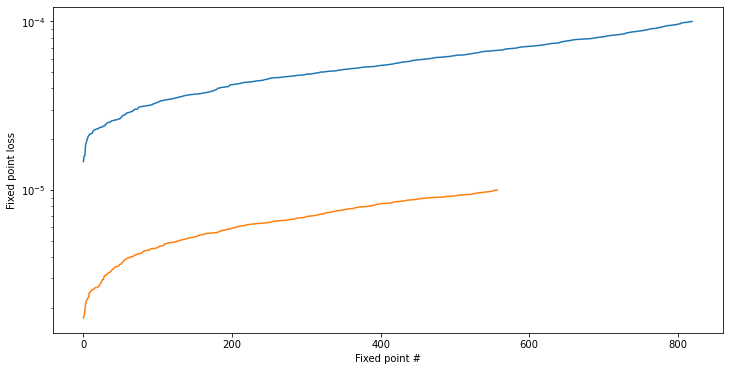

In [69]:
f1 = plt.figure(figsize=(12,6))

for tol in fp_tols: 
    plt.semilogy(all_fps[tol]['losses']); 
    plt.xlabel('Fixed point #')
    plt.ylabel('Fixed point loss');
plt.legend(fp_tols)
plt.title('Fixed point loss by fixed point (sorted) and stop tolerance')

f2 = plt.figure(figsize=(12,4))

pidx = 1
nfp_tols = len(fp_tols)
for tol_idx, tol in enumerate(fp_tols):
    plt.subplot(1, nfp_tols, pidx); pidx += 1
    plt.hist(onp.log10(fp_loss_fun(all_fps[tol]['fps'])), 50);
    plt.xlabel('log10(FP loss)')
    plt.title('Tolerance: ' + str(tol));

Try to get a nice representation of the line using the fixed points

In [ ]:
# Sort the best fixed points by projection onto the readoud.
best_tol = fp_tols[-1]
fps = all_fps[best_tol]['fps']
fp_readouts = onp.squeeze(onp.dot(params['wO'], fps.T) + onp.expand_dims(params['bO'], axis=1))
fp_ro_sidxs = onp.argsort(fp_readouts)
sorted_fp_readouts = fp_readouts[fp_ro_sidxs]
sorted_fps = fps[fp_ro_sidxs]

downsample_fps = 2 # Use this if too many fps
sorted_fp_readouts = sorted_fp_readouts[0:-1:downsample_fps]
print(len(sorted_fp_readouts))
sorted_fps = sorted_fps[0:-1:downsample_fps]
jacs = fp_optimize.compute_jacobians(rnn_fun, sorted_fps)
eig_decomps = fp_optimize.compute_eigenvalue_decomposition(jacs, sort_by='real', do_compute_lefts=True)

Let's run the system starting at these fixed points, without input, and make sure the system is at equilibrium there. Note one can have fixed points that are very unstable, but that does not show up in this example.

In [ ]:
def no_inputs_no_targets_h0s(keys):
    nkeys = len(keys)
    inputs_b = np.zeros([nkeys, ntimesteps, u])
    targets_b = np.zeros([nkeys, ntimesteps, o]) 
    h0s_b = sorted_fps[:nkeys,:]
    masks_b = None
    return inputs_b, targets_b, masks_b, h0s_b

rnn_run = lambda inputs_b, h0s_b: rnn.batched_rnn_run_w_h0(params, inputs_b, h0s_b)

nexamples = len(sorted_fps)
rnn_internals_slow = rnn.run_trials(rnn_run, no_inputs_no_targets_h0s, 1, nexamples)

rnn.plot_examples(ntimesteps, rnn_internals_slow, 4)

# Analysis

Now, through a series of plots and dot products, we will see how the GRU solved the binary decision task. First we plot the fixed points, the fixed point candidates that the fixed point optimization was seeded with.

* Black shows the original candidate point, the colored stars show the fixed point, where the color of the fixed point is the projection onto the readout vector and the size is commensurate with how slow it is (slower is larger).

* So in this example, we see that the fixed point structure implements an approximate line attractor, which is the one-dimensional manifold likely used to integrate the white noise and ultimately lead to the decision.

* Note also the shape of the manifold relative to the color.  The color is the based on the readout value of the fixed point, so it appears that there may be three parts to the line attractor.  The middle and two sides.  The two sides may be integrating, even though the the readout would be +1 or -1.

In [ ]:
from sklearn.decomposition import PCA
fig = plt.figure(figsize=(16,16));
ax = fig.add_subplot(111, projection='3d');

pca = PCA(n_components=3).fit(fp_candidates)


max_fps_to_plot = 1000
sizes = [100, 500]
for tol, size in zip(fp_tols[1:2], sizes):
    hiddens = all_fps[tol]['candidates']

    h_pca = pca.transform(hiddens)

    emax = h_pca.shape[0] if h_pca.shape[0] < max_fps_to_plot else max_fps_to_plot

    alpha = 0.01
    ax.scatter(h_pca[0:emax,0], h_pca[0:emax,1], h_pca[0:emax,2], color=[0, 0, 0, 0.1], s=10)

    hstars = np.reshape(all_fps[tol]['fps'], (-1, n))
    hstar_pca = pca.transform(hstars)
    color = onp.squeeze(onp.dot(params['wO'], hstars.T) + onp.expand_dims(params['bO'], axis=1))
    color = onp.where(color > 1.0, 1.0, color)
    color = onp.where(color < -1.0, -1.0, color)
    color = (color + 1.0) / 2.0    
    
    marker_style = dict(marker='*', s=size, edgecolor='gray')
    
    ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
                c=color[0:emax], **marker_style);

    for eidx in range(emax):
        ax.plot3D([h_pca[eidx,0], hstar_pca[eidx,0]], 
                  [h_pca[eidx,1], hstar_pca[eidx,1]],
                  [h_pca[eidx,2], hstar_pca[eidx,2]], c=[0, 0, 1, alpha])    
        
plt.title('Fixed point structure and fixed point candidate starting points.');
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3');

It's worth taking a look at the fixed points, and the trajectories started at the fixed points, without any input, all plotted in the 3D PCA space.

In [ ]:
fig = plt.figure(figsize=(16,16));
ax = fig.add_subplot(111, projection='3d');


all_hiddens = onp.reshape(rnn_internals_slow['hiddens'], (-1, n))
pca = PCA(n_components=3).fit(fp_candidates)

alpha = 0.05
emax = nexamples
for eidx in range(emax):
    h_pca = pca.transform(rnn_internals_slow['hiddens'][eidx,:,:])
    ax.plot3D(h_pca[:,0], 
              h_pca[:,1],
              h_pca[:,2], c=[0, 0, 1, alpha])    

        
size = 100
hstar_pca = pca.transform(sorted_fps)
color = onp.squeeze(onp.dot(params['wO'], sorted_fps.T) + onp.expand_dims(params['bO'], axis=1))
color = onp.where(color > 1.0, 1.0, color)
color = onp.where(color < -1.0, -1.0, color)
color = (color + 1.0) / 2.0    
marker_style = dict(marker='*', s=size, edgecolor='gray')


ax.scatter(hstar_pca[0:emax,0], hstar_pca[0:emax,1], hstar_pca[0:emax,2], 
           c=color[0:emax], **marker_style);

plt.title('High quality fixed points and the network dynamics initialized from them.');
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3');


# Analysis of linearized systems around the fixed points.

Glancing up at the trained parameters plot, you can see the eigenvalues of the GRU linearized around the trained initial condition, $h_0$. These eigenvalues are plotted in the complex plane.  There is one eigenvalue very close to $(1,0)$ in the complex plane, this means the system can integrate.  The rest of the eigenvalues are within the unit circle, meaning they are stable, decaying modes.  For this example, we can safely ignore all the modes except the first one.

Below, we plot the top eigenvalues as a function of the location on the readout. The top eigenvalue is very close to $(1,0)$ across the line readout.


In [ ]:
neigs = 3
plt.figure(figsize=(neigs*5, 3))
for eidx in range(neigs):
    max_eigs = []
    for decomp in eig_decomps:
        evals = decomp['evals']
        max_eigs.append(onp.real(evals[eidx]))

    max_eigs = onp.array(max_eigs)

    plt.subplot(1,neigs,eidx+1)
    plt.scatter(sorted_fp_readouts, max_eigs, c=sorted_fp_readouts);
    plt.plot([-1,1,], [1, 1], 'k')
    plt.axis('tight')
    plt.title('Eigenvalue # ' + str(eidx))
    plt.xlabel('Readout projection')


Another major quantity of interest is what the right and left eigenvectors are doing.

Here, we will comment exclusively on the right eigenvectors.  The right eigenvectors give the direction in which the system will integrate input.  Projecting the right eigenvectors on the readout of the GRU is a very natural thing to do then, because it shows when input is integrated to move the readout (if the readout of the right eigenvector and the readout is high), vs. when the input is integrated and does not change the readout projection (if the readout of the right eigenvector and the readout is very small, basically orthogonal).

Notice that the projection between the right maximal eigenvalue and the readout varies as a function of the location of the fixed point.  This is very curious and points to how the nonlinear GRU is solving the binary decision task.

In [ ]:
ldots = []
rdots = []
rdotla = []

color = onp.squeeze(onp.dot(params['wO'], sorted_fps.T) + onp.expand_dims(params['bO'], axis=1))
color = onp.where(color > 1.0, 1.0, color)
color = onp.where(color < -1.0, -1.0, color)
color = (color + 1.0) / 2.0    

nfps = len(sorted_fps)
for jidx in range(nfps):
    fp = sorted_fps[jidx, :]
    rnn_fun_x = lambda x : rnn.gru(params, fp, x)
    dfdx = jacrev(rnn_fun_x)
    r0 = onp.real(eig_decomps[jidx]['R'][:, 0])                          
    rdots.append(onp.dot(r0, params['wO'].T))
    l0 = onp.real(eig_decomps[jidx]['L'][:, 0])
    ldots.append(onp.dot(l0, dfdx(onp.ones([1]))))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(sorted_fp_readouts, onp.abs(rdots), c=color)
plt.title('Rights dotted with readout')
plt.subplot(122)
plt.scatter(sorted_fp_readouts, onp.abs(ldots), c=color)
plt.title('Lefts dotted with effective input')
plt.ylim([0, 3]);

Three other sets of dot products give a nearly complete story. 

1. Dot product of fixed points with the readout as a function of where the fixed point is on the line attractor.  They are either very high, or very low.  
2. Dot product of the local direction of the line attractor (the tangent of the line) and readout.  This shows that most of the line attractor motion is orthogonal to the readout, thus implementing something approximating a decision boundary. 
3. Dot product of the right maximal eigenvector with the local direction of the line attractor. While a bit messy, this shows that the direction local integration, as given by the right maximal eigenvector, is always lined up with the line attractor tangent, _regardless_ of the projection onto the readout. 

In [ ]:
rdotsla = []
la_dots = []
la_locs = []
la_path_int = [0.0]
naround = 3
la_last = sorted_fps[naround-1,:]
for jidx in range(naround, nfps-naround):
    idxs = onp.arange(jidx-naround, jidx+naround+1)
    v1 = sorted_fps[idxs[0],:]
    v2 = sorted_fps[idxs[-1],:]
    la = (v2-v1)/onp.linalg.norm(v2-v1) # approximate line attractor direction.
    la_dots.append(onp.dot(la, params['wO'].T))
    la_locs.append(onp.squeeze(onp.dot(onp.mean(sorted_fps[idxs,:], axis=0), params['wO'].T) + params['bO']))
    la_path_int.append(la_path_int[-1] + onp.linalg.norm(la-la_last))
    la_last = la

    r0 = onp.real(eig_decomps[jidx]['R'][:, 0])
    rdotsla.append(onp.abs(onp.dot(r0, la.T)))

    
la_dots = onp.array(la_dots)
la_locs = onp.array(la_locs)
la_path_int = onp.array(la_path_int)
la_path_int = la_path_int[1:]

color2 = color[naround: -naround]
    
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.scatter(la_locs, la_dots, c=color2)
plt.xlabel('Readout of fixed point location')
plt.title('Line attractor direction dotted with readout')
plt.subplot(132)
plt.scatter(la_path_int, la_dots, c=color2)
plt.xlabel('Line attractor path integral')
plt.title('Line attractor direction dotted with readout');
plt.subplot(133)
plt.scatter(la_path_int, rdotsla)
plt.xlabel('Line attractor path integral')
plt.title('Line attractor direction dotted with right 0 eigenvector');


# Solution to the GRU decision task.
So it seems pretty clear how the system solved this decision task. 
* The GRU created a 1-dimensional manifold of fixed points, also known as a line attractor.  This line attractor is good at holding an analog memory, such as the integral of white noise input. 
* Local linear dynamics integrated the input along the line attractor.
* The GRU then __bent__ and __aligned__ that line attractor, such that most path was orthogonal to the readout vector.  
* Thus, the GRU could jump from +1 to -1 readout, while still adjusting it's confidence of the decision, based on the white noise integral.

# Homework Assignment

Change the error of the readout to cross-entropy error, drop the mean-squared error.  What changes, what stays the same?